# Summary

----

# Imports

In [394]:
%run _imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2017-12-21 00:38:31.698555


In [395]:
NOTEBOOK_NAME = 'query_mutation_tables'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Parameters

In [396]:
ARCHIVE_DIR = Path('archive_to_hdf5/pmc_archives_1/').absolute()
ARCHIVE_DIR

PosixPath('/kimlab2/database_data/datapkg/pmc-tables/notebooks/archive_to_hdf5/pmc_archives_1')

# Gene names

## Load human gene information from HUGO

In [397]:
df = pd.read_csv(
    'ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/tsv/locus_groups/protein-coding_gene.txt',
    sep='\t'
)

KeyboardInterrupt: 

In [ ]:
display(df.head())
print(len(df))

## Construct gene signatures

In [ ]:
len(df.drop_duplicates('symbol'))

#### `gene_symbol`

In [ ]:
gene_symbol = set(df['symbol'].dropna())
len(gene_symbol)

#### `gene_synonym`

In [ ]:
gene_synonym = {
    **{v: k for k, vv in df[['symbol', 'alias_symbol']].dropna().values for v in vv.split('|')},
    **{v: k for k, v in df[['symbol', 'prev_symbol']].dropna().values},
}
len(gene_synonym)

#### `ensembl_gene_id`

In [ ]:
assert not df['ensembl_gene_id'].dropna().str.contains('\|').any()
ensembl_gene_id = {v: k for k, v in df[['symbol', 'ensembl_gene_id']].dropna().values}
len(ensembl_gene_id)

#### `refseq_accession`

In [ ]:
assert not df['ensembl_gene_id'].dropna().str.contains('\|').any()
refseq_accession = {v: k for k, v in df[['symbol', 'refseq_accession']].dropna().values}
len(refseq_accession)

#### `uniprot_ids`

In [ ]:
uniprot_ids = {v: k for k, vv in df[['symbol', 'uniprot_ids']].dropna().values for v in vv.split('|')}
len(uniprot_ids)

#### `cosmic`

In [ ]:
assert not df['cosmic'].dropna().str.contains('\|').any()
cosmic = {v: k for k, v in df[['symbol', 'cosmic']].values}
len(cosmic)

## Save gene signatures

In [ ]:
gene_signatures = dict(
    gene_symbol=gene_symbol,
    gene_synonym=gene_synonym,
    ensembl_gene_id=ensembl_gene_id,
    refseq_accession=refseq_accession,
    uniprot_ids=uniprot_ids,
    cosmic=cosmic,
)

In [ ]:
with open(f"{NOTEBOOK_NAME}/gene_signatures.pickle", 'wb') as fout:
    pickle.dump(gene_signatures, fout, pickle.HIGHEST_PROTOCOL)

# Run jobs

## Job parameters

In [ ]:
JOB_ID = 'job_0'
DATA_ID = 'mutation_tables_0'

In [ ]:
JOB_DIR = f"~/datapkg/{os.environ['DB_SCHEMA']}/notebooks/{NOTEBOOK_NAME}/{JOB_ID}"
DATA_DIR = f"~/datapkg/{os.environ['DB_SCHEMA']}/notebooks/{NOTEBOOK_NAME}/{DATA_ID}"

os.makedirs(op.expanduser(JOB_DIR), exist_ok=True)
os.makedirs(op.expanduser(DATA_DIR), exist_ok=True)
print(JOB_DIR, DATA_DIR, sep='\n')

In [ ]:
ENV = {
    'PATH': '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/usr/bin:/bin',
    'OMP_NUM_THREADS': '1',
    'OPENMM_CPU_THREADS': '1',
}

## Script file

In [ ]:
%%file {DATA_DIR}.py
import time
import os.path as op
import json
import pickle
import warnings
import logging
from pathlib import Path

import tables
import pandas as pd

import pmc_tables

warnings.filterwarnings("ignore", category=tables.NaturalNameWarning)
logger = logging.getLogger(__name__)


with open(op.join(op.dirname(op.abspath(__file__)), 'gene_signatures.pickle'), 'rb') as fin:
    GENE_SIGNATURES = pickle.load(fin)


def match_tables_in_file(hdf5_file):
    matching_tables = []
    with pd.HDFStore(hdf5_file, 'r') as store:
        counter = 0
        for pmc_node in store.root._f_iter_nodes():
            counter += 1
            if counter > 100_0000:
                break
            pmc_matching_tables = match_tables_in_node(pmc_node, store)
            matching_tables += pmc_matching_tables
    return matching_tables    
    

def match_tables_in_node(pmc_node, store):
    pmc_matching_tables = []
    for file_node in pmc_node._f_iter_nodes():
        for table_node in file_node._f_iter_nodes():
            try:
                child = table_node._f_get_child('table')
            except tables.NoSuchNodeError:
                logger.error(f"No such node: {table_node._v_name}/table")
                continue
            try:
                df = pd.read_hdf(store, key=table_node._v_pathname)
                match = _check_if_table_matching(df)
                if match is not None:
                    pmc_matching_tables.append((table_node._v_pathname, ) + match)
            except Exception as e:
                logger.error(f"The following exception occured: {type(e)}: {e}")
                pass
    return pmc_matching_tables


def _check_if_table_matching(df):
    obj_columns = df.dtypes[df.dtypes == object].index.tolist()
    # Match gene columns
    gene_column_match = None
    for c in obj_columns:
        if gene_column_match is not None:
            break
        for gene_set in GENE_SIGNATURES.values():
            frac_contained = df[c].dropna().isin(gene_set).sum() / len(df)
            if frac_contained > 0.9:
                gene_column_match = c
                break
    if gene_column_match is None:
        return None
    # Match mutation columns
    mutation_column_match = None
    for c in obj_columns:
        frac_mutation = df[c].dropna().str.match('[a-zA-Z]\d+[a-zA-Z]').sum() / len(df)
        if frac_mutation > 0.8:
            mutation_column_match = c
            break
    # Return results
    if mutation_column_match is None:
        return None
    return gene_column_match, mutation_column_match
    

def main(hdf5_file):
    start_time = time.perf_counter()
    matching_tables = match_tables_in_file(hdf5_file)
    runtime = time.perf_counter() - start_time
    
    results = {
        'runtime': runtime,
        'num_matching_tables': len(matching_tables),
        'matching_tables_info': matching_tables,
    }
    return results


def _dump_list(lst):
    return pmc_tables.utils.compress_to_b85(pickle.dumps(lst)).decode('ascii')


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-i', '--input-file')
    parser.add_argument('-o', '--output-dir')
    args = parser.parse_args()

    logging.basicConfig(format='[%(name)s] %(message)s', level=logging.DEBUG)

    hdf5_file = Path(args.input_file).absolute()
    output_dir = Path(args.output_dir).absolute()

    results = main(hdf5_file)
    
    output_file = output_dir.joinpath(hdf5_file.stem).with_suffix('.pickle')

    with output_file.open('wb') as fout:
        pickle.dump(results, fout)

## System commands

In [ ]:
system_commands = []

for input_file in ARCHIVE_DIR.glob('*.h5'):
    if input_file.parts[1] != 'home':
        input_file = Path('/home').joinpath(*input_file.parts[1:])
    output_dir = Path(DATA_DIR).expanduser()
    if output_dir.parts[1] != 'home':
        output_dir = Path('/home').joinpath(*output_dir.parts[1:])
    system_command = f'python "../{DATA_ID}.py" -i "{input_file}" -o "{output_dir}"'
    system_commands.append(system_command)
    
system_commands = pd.DataFrame(system_commands, columns=['system_command'])

In [ ]:
len(system_commands)

In [ ]:
!(cd {DATA_DIR}; echo {system_commands.iat[1, 0]})

In [ ]:
# !(cd {DATA_DIR}; {system_commands.iat[1, 0]})

In [ ]:
with open('/home/kimlab1/strokach/datapkg/pmc-tables/notebooks/query_mutation_tables/mutation_tables_0/f5.pickle', 'rb') as fin:
    data = pickle.load(fin)

In [ ]:
data

## Submit

In [ ]:
import jobsubmitter

importlib.reload(jobsubmitter)

In [ ]:
js = jobsubmitter.JobSubmitter('beagle', JOB_DIR, DATA_DIR, ENV)
js

In [ ]:
jo = jobsubmitter.JobOpts(JOB_ID, nproc=1, queue='medium', walltime='24:00:00', mem='6G')
jo

In [ ]:
logging.getLogger().setLevel(logging.INFO)

In [ ]:
len(system_commands)

In [ ]:
# futures = js.submit(system_commands, jo, deplay=0.02)

**Results:**

In [ ]:
results = js.job_status(system_commands)

In [ ]:
results[results['system_command'].str.contains('b1\.h5')]

In [ ]:
done = results[results['status'] == 'done']
print(len(done))

In [ ]:
remaining = results[(results.index == 34) | (results['status'] != 'done')]
print(len(remaining))

In [ ]:
remaining

**Do this in a loop until done...**

In [ ]:
futures = js.submit(remaining, jo, deplay=0.02)

In [ ]:
results2 = js.job_status(system_commands)

In [ ]:
failed = results2[results2['status'] != 'done']
print(len(failed))

## Collect results

In [ ]:
hdf5_files = list(ARCHIVE_DIR.glob('*.h5'))

In [ ]:
result_files = list(Path(DATA_DIR).expanduser().glob('*.pickle'))
print(result_files[:3])
assert len(result_files) == len(hdf5_files), (len(result_files), len(hdf5_files))

In [ ]:
all_data = []

for result_file in result_files:
    with result_file.open('rb') as fin:
        data = pickle.load(fin)
    for table_id, protein_column, mutation_column in data['matching_tables_info']:
        all_data.append((table_id, protein_column, mutation_column))

In [ ]:
data_df = pd.DataFrame(all_data, columns=['table_id', 'protein_column', 'mutation_column'])

In [ ]:
display(data_df.head())
print(len(data_df))

In [ ]:
gene_columns = Counter(data_df['protein_column']).most_common()[:10]

In [ ]:
mutation_columns = Counter(data_df['mutation_column']).most_common()[:10]

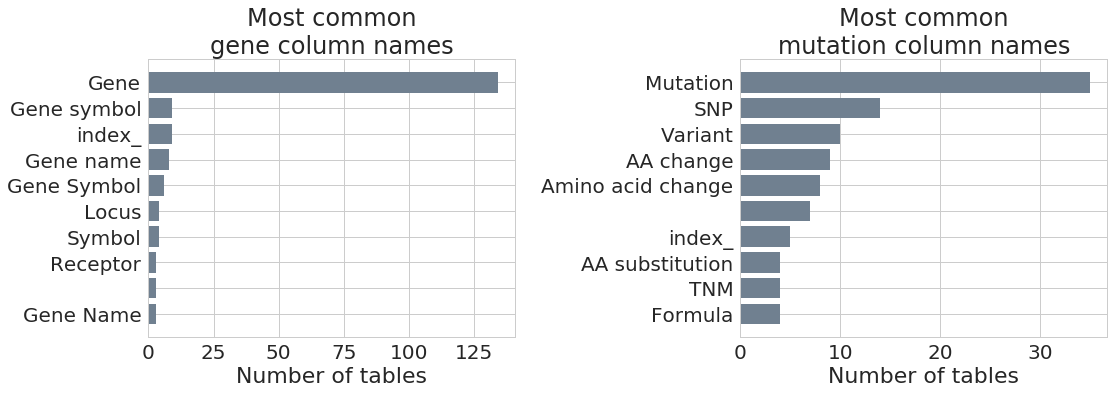

In [418]:
fg, axs = plt.subplots(1, 2, figsize=(16, 6))

plt.axes(axs[0])
plt.barh(
    range(10),
    [g[1] for g in reversed(gene_columns)],
    color='slategrey'

)
plt.yticks(range(10), [g[0] for g in reversed(gene_columns)])
plt.xlabel("Number of tables")
plt.title("Most common\ngene column names")

plt.axes(axs[1])
plt.barh(
    range(10),
    [g[1] for g in reversed(mutation_columns)],
    color='slategrey'
)
plt.yticks(range(10), [g[0] for g in reversed(mutation_columns)])
plt.xlabel("Number of tables")
plt.title("Most common\nmutation column names")

plt.tight_layout()
plt.savefig(f'{NOTEBOOK_NAME}/most_common_column_names.pdf', bbox_index='tight')
plt.savefig(f'{NOTEBOOK_NAME}/most_common_column_names.png', dpi=300, bbox_index='tight')

In [ ]:
top_gene_columns = Counter(data_df['protein_column']).most_common()[:10]

In [ ]:
top_mutation_columns = Counter(data_df['mutation_column']).most_common()[:10]

In [ ]:
table_stats_df = pd.read_csv('project_report/table_stats.csv')

In [ ]:
table_stats_df.head()

In [ ]:
grps = table_stats_df.groupby('pmc_id')['table_name'].count()

In [ ]:
plt.hist(grps.values, range=(0, 10), bins=20)

In [ ]:
table_stats_matches.to_csv(f'{NOTEBOOK_NAME}/table_stats_matches.csv', index=False)

In [ ]:
table_stats_matches = table_stats_df.merge(
    data_df.rename(columns={'table_id': 'table_name'}), on='table_name', how='inner')

In [ ]:
table_stats_matches.head()

In [ ]:
assert len(table_stats_matches) == len(data_df)

In [ ]:
df = table_stats_matches['num_rows'].dropna()

plt.hist(df, range=(0, 40), bins=40, alpha=0.8)

plt.xlabel("Number of rows")
plt.ylabel("Number of tables")
plt.title(f"All tables (n = {len(df):2,})")

In [ ]:
df = table_stats_matches['num_columns'].dropna()

plt.hist(df, range=(0, 40), bins=40, alpha=0.8, facecolor='green')

plt.xlabel("Number of columns")
plt.ylabel("Number of tables")

In [ ]:
table_stats_matches['num_rows'].sum()

In [ ]:
table_stats_matches['num_rows'].max()